In [1]:
from datasets import load_dataset

In [2]:
emotions = load_dataset("emotion")

D:\Anaconda\envs\data_sid\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [11]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


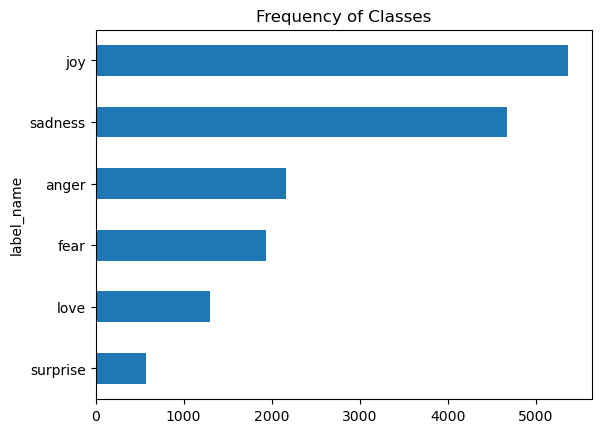

In [12]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

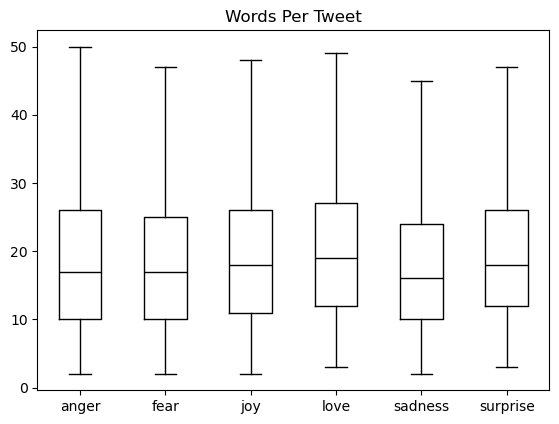

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name",grid=False,showfliers=False,color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions.reset_format()

In [15]:
from transformers import DistilBertTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [16]:
def tokenize(batch):
    return tokenizer(batch["text"],padding=True,truncation=True)

In [17]:
emotions_encoded = emotions.map(tokenize,batched=True,batch_size=None)

In [18]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [19]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Feature Extraction Method

In [20]:
from transformers import AutoModel
import torch
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state":last_hidden_state[:,0].cpu().numpy()
           }

In [22]:
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])

In [23]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [24]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [25]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [26]:
import numpy as np

In [27]:
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])

y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [28]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [29]:
X_scaled =  MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2,metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_,columns=['X','Y'])

In [30]:
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.384840,6.023948,0
1,-2.946742,5.062392,0
2,5.357047,2.621044,3
3,-2.034942,3.145970,2
4,-3.056620,3.174354,3


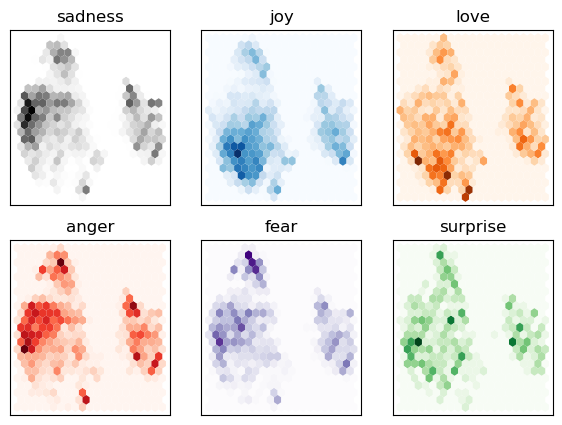

In [31]:
fig,axes = plt.subplots(2,3,figsize=(7,5))
axes = axes.flatten()

cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i,(label,cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub = df_emb.query(f"label =={i}")
    axes[i].hexbin(df_emb_sub["X"],df_emb_sub["Y"],cmap=cmap,gridsize=20,linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]),axes[i].set_yticks([])

In [32]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)


0.6345

In [33]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf = dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid,y_valid)

0.352

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_pred,y_true,labels):
    cm= confusion_matrix(y_true,y_pred,normalize="true")
    fig,ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap="Blues",values_format=".2f",ax=ax,colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

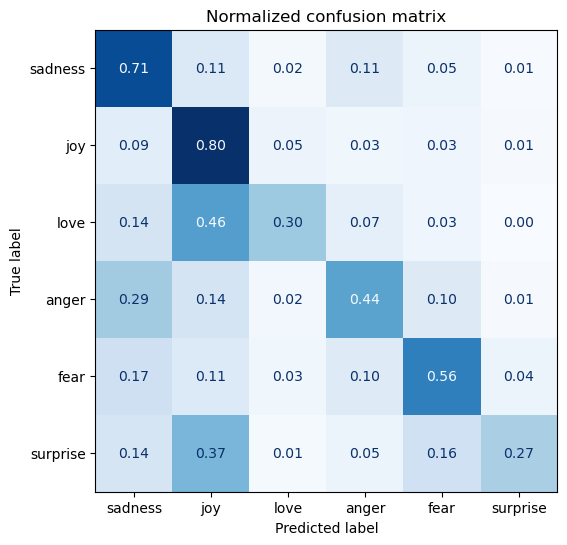

In [35]:
y_pred = lr_clf.predict(X_valid)
plot_confusion_matrix(y_pred,y_valid,labels)

In [36]:
from transformers import AutoModelForSequenceClassification

In [37]:
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_labels).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.

In [38]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average="weighted")
    acc = accuracy_score(labels,preds)

    return {
        "accuracy":acc,
        "f1":f1
    }

In [39]:
!pip install transformers[torch]

In [40]:
!pip install accelerate -U

In [41]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"

)

In [42]:
!pip install ipywidgets

In [43]:
from huggingface_hub import notebook_login
notebook_login()

In [44]:
trainer  = Trainer(model=model,args=training_args,compute_metrics=compute_metrics,train_dataset=emotions_encoded["train"],eval_dataset=emotions_encoded["validation"],tokenizer=tokenizer)
trainer.train()

D:\Anaconda\envs\data_sid\Lib\site-packages\huggingface_hub\utils\_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/sidsitaula/distilbert-base-uncased-finetuned-emotion into local empty directory.
D:\Anaconda\envs\data_sid\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.822500,0.331642,0.895500,0.890710
2,0.248800,0.216663,0.927500,0.927463


TrainOutput(global_step=500, training_loss=0.5356386413574219, metrics={'train_runtime': 643.5203, 'train_samples_per_second': 49.726, 'train_steps_per_second': 0.777, 'total_flos': 720342861696000.0, 'train_loss': 0.5356386413574219, 'epoch': 2.0})

In [45]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [46]:
preds_output.metrics

{'test_loss': 0.2166629284620285,
 'test_accuracy': 0.9275,
 'test_f1': 0.9274629734436546,
 'test_runtime': 7.6103,
 'test_samples_per_second': 262.801,
 'test_steps_per_second': 4.205}

In [48]:
y_preds = np.argmax(preds_output.predictions,axis=1)

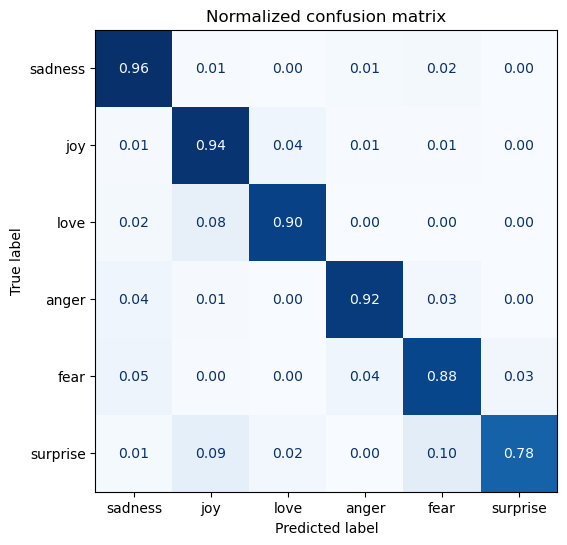

In [49]:
plot_confusion_matrix(y_preds,y_valid,labels)